In [1]:
%matplotlib inline
import glob
import re
import os
import pickle
import math
import numpy as np
import scipy
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches

plt.rcParams['font.family'] = 'Times New Roman'

In [2]:
def plot_simple(basename, ax, label=None, test=False, style="-"):
    if test:
        fname = basename + "_test.log"
    else:
        fname = basename + ".log"
    try:
        data = np.loadtxt(fname)
    except:
        print("Could not load", fname)
        return
    if label is None:
        label = basename
    if test:
        ax.plot(data[:, 0], data[:, 2], label=label, linestyle=style)
    else:
        ax.plot(data[:, 0], data[:, 1], label=label, linestyle=style)


def average_nll(base_name, xmin, xmax, nbin=100):
    flists = glob.glob(f"{base_name}_*.log")
    nlls = np.zeros((2, nbin))
    std = np.zeros((2, nbin))
    count_nlls = np.zeros((2, nbin), dtype=int)
    for fname in flists:
        x = np.loadtxt(fname)
        if re.match(r".*_test.log", fname):
            v_index = 2
        else:
            v_index = 1
        for i in range(nbin):
            x0 = xmin + (xmax - xmin) * i / nbin
            x1 = xmin + (xmax - xmin) * (i + 1) / nbin
            z = x[(x0 <= x[:, 0]) & (x[:, 0] < x1), v_index]
            if len(z) == 0:
                continue
            m = np.mean(z)
            nlls[v_index - 1, i] += m
            std[v_index - 1, i] += m * m
            count_nlls[v_index - 1, i] += 1
    for i in range(2):
        xindex = count_nlls[i, :] > 0
        nlls[i, xindex] /= count_nlls[i, xindex]
        xindex = count_nlls[i, :] > 1
        std[i, xindex] = np.sqrt(
            (std[i, xindex] - nlls[i, xindex] * nlls[i, xindex] * count_nlls[i, xindex])
            / (count_nlls[i, xindex] - 1)
        )
        xindex = count_nlls[i, :] == 0
        nlls[i, xindex] = np.nan
        std[i, xindex] = np.nan
        xindex = count_nlls[i, :] == 1
        std[i, xindex] = 0
    return (np.arange(nbin) + 0.5) * (xmax - xmin) / nbin + xmin, nlls, std, count_nlls

Text(0, 0.5, 'Negative log-likelihood')

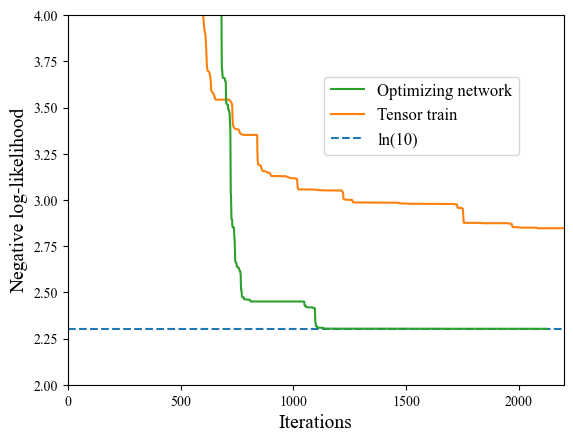

In [4]:
fig, ax = plt.subplots()
i = 230700
nleaf = 128
labels = ["Tensor train", "Optimizing network"]
ax.plot([0, 3500], [math.log(10), math.log(10)], linestyle="--", label="ln(10)")

TY = 0
ST = 1
plot_simple(
    f"./Results/bm_random_TY{TY}_ST{ST}_ALG0_ALP0.05_MAX1_D10_NS10_SE{i}_XS{i}",
    ax,
    labels[0],
)
ST = 3
plot_simple(
    f"./Results/bm_random_TY{TY}_ST{ST}_ALG0_ALP0.05_MAX1_D10_NS10_SE{i}_XS{i}",
    ax,
    labels[1],
)
handles, labels = ax.get_legend_handles_labels()
ax.legend(
    handles=handles[::-1], labels=labels[::-1], bbox_to_anchor=(0.5, 0.6), fontsize=12
)
ax.set_ylim(2, 4)
ax.set_xlim(0, 2200)
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.set_xlabel("Iterations", fontsize=14)
ax.set_ylabel("Negative log-likelihood", fontsize=14)

Text(0, 0.5, 'Negative log-likelihood')

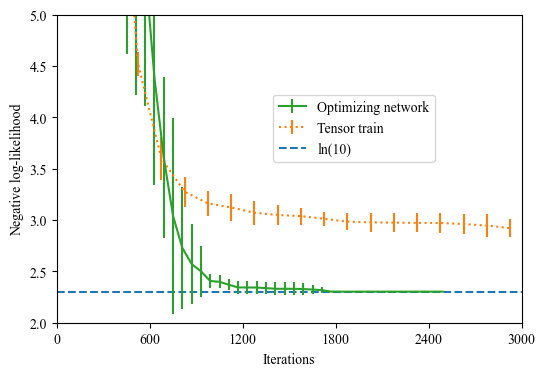

In [5]:
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
ax.plot([0, 3000], [math.log(10), math.log(10)], linestyle="--", label="ln(10)")

TY = 0
ST = 1
base_name = f"./Results/bm_random_TY{TY}_ST{ST}_ALG0_ALP0.05_MAX1_D10_NS10"
x, y, std, count = average_nll(base_name, 0, 3000, 20)
ax.errorbar(x, y[0, :], yerr=std[0, :], label="Tensor train", linestyle=":")
TY = 0
ST = 3
base_name = f"./Results/bm_random_TY{TY}_ST{ST}_ALG0_ALP0.05_MAX1_D10_NS10"
x, y, std, count = average_nll(base_name, 0, 3000, 50)
ax.errorbar(x, y[0, :], yerr=std[0, :], label="Optimizing network")
ax.set_ylim(2, 5)
ax.set_xlim(0, 3000)
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles=handles[::-1], labels=labels[::-1], bbox_to_anchor=(0.45, 0.5))
ax.xaxis.set_major_locator(plt.MaxNLocator(5))
ax.set_xlabel("Iterations")
ax.set_ylabel("Negative log-likelihood")